In [7]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


dataset = 'D1'

df = pd.read_csv('alltrials.csv', sep=';')
data = df[df['f1']!=0]



# Threshold to categorical

In [27]:
# Transform threshold to categorical
step=0.01
data['threshold_categorical'] = pd.cut(data['threshold'], 
                                       bins=np.arange(0, 1.0+step, step),
                                       labels=[str(round(i,2))+"-"+str(round(i+step,2)) for i in np.arange(0, 1, step)])

In [28]:
data[['threshold_categorical', 'threshold']]

,threshold_categorical,threshold
1,0.04-0.05,0.050000
4,0.72-0.73,0.725000
6,0.04-0.05,0.050000
9,0.72-0.73,0.725000
10,0.38-0.39,0.387500
...,...,...
41028,0.2-0.21,0.202816
41029,0.09-0.1,0.092164
41030,0.46-0.47,0.461966
41032,0.53-0.54,0.531726


<Axes: xlabel='threshold_categorical'>

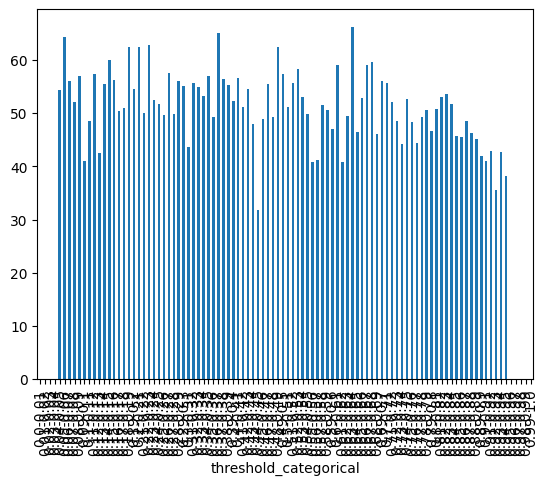

In [29]:
# group by categorical threshold and get the mean of f1
data.groupby('threshold_categorical')['f1'].mean().plot(kind='bar')

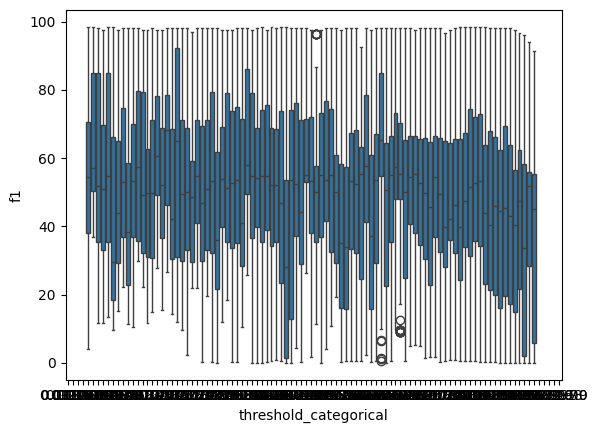

In [30]:
# plot the distribution of f1 for each threshold
sns.boxplot(x='threshold_categorical', y='f1', data=data)
plt.show()


# F-score to categorical

In [ ]:
# create a new column containing f1 per dataset having High if its the top 5% highest f1, Low otherwise
data['f1_high'] = data['f1'] > data['f1'].quantile(0.95)

In [47]:
data['k'] = data['k'].astype(str)

testD = data[data['dataset']==dataset]
trainD = data[data['dataset']!=dataset]

features = ['clustering', 'lm', 'k', 'threshold_categorical', 'InputEntityProfiles', 'NumberOfAttributes', 'NumberOfDistinctValues', 
            'NumberOfNameValuePairs', 'AverageNVPairsPerEntity', 'AverageDistinctValuesPerEntity', 
            'AverageNVpairsPerAttribute', 'AverageDistinctValuesPerAttribute', 'NumberOfMissingNVpairs', 
            'AverageValueLength', 'AverageValueTokens', 'MaxValuesPerEntity']
target_features = ['clustering', 'lm', 'k', 'threshold_categorical']

X_train = trainD[features]
y_train = trainD[target_features]

X_test = testD[features]
y_test = testD[target_features]

In [52]:
diff = X_train.columns.difference(X_test.columns)
print(diff)

Index([], dtype='object')


In [48]:
X_train_dummy = pd.get_dummies(X_train)
X_test_dummy = pd.get_dummies(X_test)

In [54]:
diff = X_train_dummy.columns.difference(X_test_dummy.columns)
print(diff)

Index(['k_78'], dtype='object')


In [57]:
X_test_dummy['k_78'] = 0

In [50]:
len(X_test_dummy.columns)

220

In [44]:
X_train_dummy.describe()

,InputEntityProfiles,NumberOfAttributes,NumberOfDistinctValues,NumberOfNameValuePairs,AverageNVPairsPerEntity,AverageDistinctValuesPerEntity,AverageNVpairsPerAttribute,AverageDistinctValuesPerAttribute,NumberOfMissingNVpairs,AverageValueLength,AverageValueTokens,MaxValuesPerEntity
count,33478.000000,33478.000000,33478.000000,33478.000000,33478.000000,33478.000000,33478.000000,33478.000000,3.347800e+04,33478.000000,33478.000000,33478.000000
mean,20975.753151,13.130175,75223.615778,164492.145797,5.298435,2.405409,20606.313950,10225.728843,7.345917e+06,183.961148,35.896122,153.199654
std,20631.761838,12.186413,129437.901221,292210.317570,4.951688,2.171739,31334.612505,14987.179064,2.055429e+07,154.524369,27.655885,408.200437
min,2152.000000,3.000000,4383.000000,4876.000000,2.270000,0.960000,1217.700000,368.220000,1.400000e+01,73.930000,14.620000,3.000000
25%,4910.000000,4.000000,9674.000000,19626.000000,3.260000,1.220000,1625.330000,692.830000,3.160000e+03,100.660000,19.380000,4.000000
50%,12928.000000,6.000000,13624.000000,44663.000000,3.280000,2.020000,3603.000000,1648.000000,4.741100e+04,108.150000,23.010000,6.000000
75%,24628.000000,18.000000,62834.000000,128458.000000,4.030000,2.200000,21409.670000,10472.330000,1.784250e+05,197.280000,39.850000,20.000000
max,63869.000000,37.000000,424346.000000,971445.000000,19.120000,8.350000,97144.500000,42434.600000,6.540000e+07,585.150000,103.270000,1306.000000


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

# Initialize the RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the MultiOutputClassifier
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)

# Train the model
multi_target_forest.fit(X_train_dummy, y_train)

# Predict on the test data
y_pred = multi_target_forest.predict(X_test_dummy)

In [59]:
y_pred

array([['UniqueMappingClustering', 'st5', '1', '0.04-0.05'],
       ['UniqueMappingClustering', 'sminilm', '25', '0.71-0.72'],
       ['UniqueMappingClustering', 'st5', '1', '0.04-0.05'],
       ...,
       ['UniqueMappingClustering', 'smpnet', '3', '0.45-0.46'],
       ['BestMatchClustering', 'st5', '78', '0.52-0.53'],
       ['BestMatchClustering', 'sent_glove', '13', '0.21-0.22']],
      dtype=object)

In [66]:
res = X_test[['lm', 'clustering', 'k', 'threshold_categorical']]

# Add the predicted values to res
res['Predicted_lm'] = y_pred[:, 0]
res['Predicted_clustering'] = y_pred[:, 1]
res['Predicted_k'] = y_pred[:, 2]
res['Predicted_threshold_categorical'] = y_pred[:, 3]

# # Add the actual values (from y_test) to res
# res['Actual_lm'] = y_test['lm'].values
# res['Actual_clustering'] = y_test['clustering'].values
# res['Actual_k'] = y_test['k'].values
# res['Actual_threshold_categorical'] = y_test['threshold_categorical'].values
# res['F1'] = y_test['threshold_categorical'].values

# Display the DataFrame with the predicted and actual values
res

,lm,clustering,k,threshold_categorical,Predicted_lm,Predicted_clustering,Predicted_k,Predicted_threshold_categorical
1,st5,UniqueMappingClustering,1,0.04-0.05,UniqueMappingClustering,st5,1,0.04-0.05
4,sminilm,UniqueMappingClustering,25,0.72-0.73,UniqueMappingClustering,sminilm,25,0.71-0.72
6,st5,UniqueMappingClustering,1,0.04-0.05,UniqueMappingClustering,st5,1,0.04-0.05
9,sminilm,UniqueMappingClustering,25,0.72-0.73,UniqueMappingClustering,sminilm,25,0.71-0.72
10,st5,KiralyMSMApproximateClustering,38,0.38-0.39,KiralyMSMApproximateClustering,st5,38,0.37-0.38
...,...,...,...,...,...,...,...,...
4042,st5,KiralyMSMApproximateClustering,82,0.2-0.21,KiralyMSMApproximateClustering,st5,81,0.19-0.2
4043,smpnet,KiralyMSMApproximateClustering,77,0.09-0.1,KiralyMSMApproximateClustering,smpnet,77,0.08-0.09
4044,smpnet,UniqueMappingClustering,3,0.46-0.47,UniqueMappingClustering,smpnet,3,0.45-0.46
4046,st5,BestMatchClustering,79,0.53-0.54,BestMatchClustering,st5,78,0.52-0.53
